# 0.0 Imports

In [159]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import HTML


from sklearn import cluster as c

## 0.1. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load dataset

In [16]:
# load 

df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape', low_memory= False)

df_raw = df_raw.drop( columns= ['Unnamed: 8'], axis = 1)
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# <font color='red'> 1.0. Descrição dos dados </font>

In [50]:
df1 = df_raw.copy()

## 1.1. Rename columns 

In [51]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [55]:
cols_new = ['invoice_no', 'stock_code', 'description','quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions 

In [56]:
print( 'Number of rows: {}'.format (df1.shape[0]))
print( 'Number of columns: {}'.format (df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3. Data types

In [57]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [58]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [74]:
# Remova na
df1 = df1.dropna (subset=['description', 'customer_id'])



print('Removed data: {:.2f}%'.format(1-(df1.shape[0] / df_raw.shape[0])))

Removed data: 0.25%


## 1.6. Change dtypes

In [80]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [84]:
# invoice_date
df1['invoice_date'] = pd.to_datetime (df1['invoice_date'], format='%d-%b-%y')

# customer_id

df1['customer_id'] = df1['customer_id'].astype ( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


## 1.7 Descriptive Statistics


# <font color='red'> 2.0. Feature Engineering </font>

In [201]:
df2= df1.copy()

## 2.1. Feature Creation

In [202]:
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [203]:
# data reference > trabalhando com id e data unico

df_ref = df2.drop(['invoice_no', 'stock_code', 'description','quantity', 'invoice_date','unit_price', 'country'], axis = 1).drop_duplicates(ignore_index=True)



In [204]:
# Cross Revenue ( Faturamento ) quantity * price = Faturamento
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary =  df2[['customer_id', 'gross_revenue']].groupby( 'customer_id').sum().reset_index()
df_ref = pd.merge ( df_ref, df_monetary, on= 'customer_id', how='left')


# Recency - Last dat purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days  # ao invés de utilizar apply estou utilizando dt para transformar em inteiro
df_recency = df_recency[['customer_id','recency_days']].copy() # fiz isso para escolher quais coluna entra no join
df_ref = pd.merge ( df_ref, df_recency, on= 'customer_id', how='left')

# Frequency
df_freq = df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge ( df_ref, df_freq, on= 'customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5288.63,302,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,330,6


# <font color='red'> 3.0. Filtragem de Variaveis </font>

In [205]:
df3 = df_ref.copy()

# <font color='red'> 4.0. EDA </font>

In [206]:
df4 = df3.copy()

# <font color='red'> 5.0. Data Preparation </font>

In [207]:
df5 = df4.copy()

# <font color='red'> 6.0. Feature Selection </font>

In [208]:
df6 = df5.copy()

# <font color='red'> 7.0. Hyperparameter Fine-Tunning</font>

In [227]:
X = df6.drop( columns=['customer_id'])

In [228]:
clusters = [2,3,4,5,6]

## 7.1. Within-Clusteer Sum of Square (WSS)

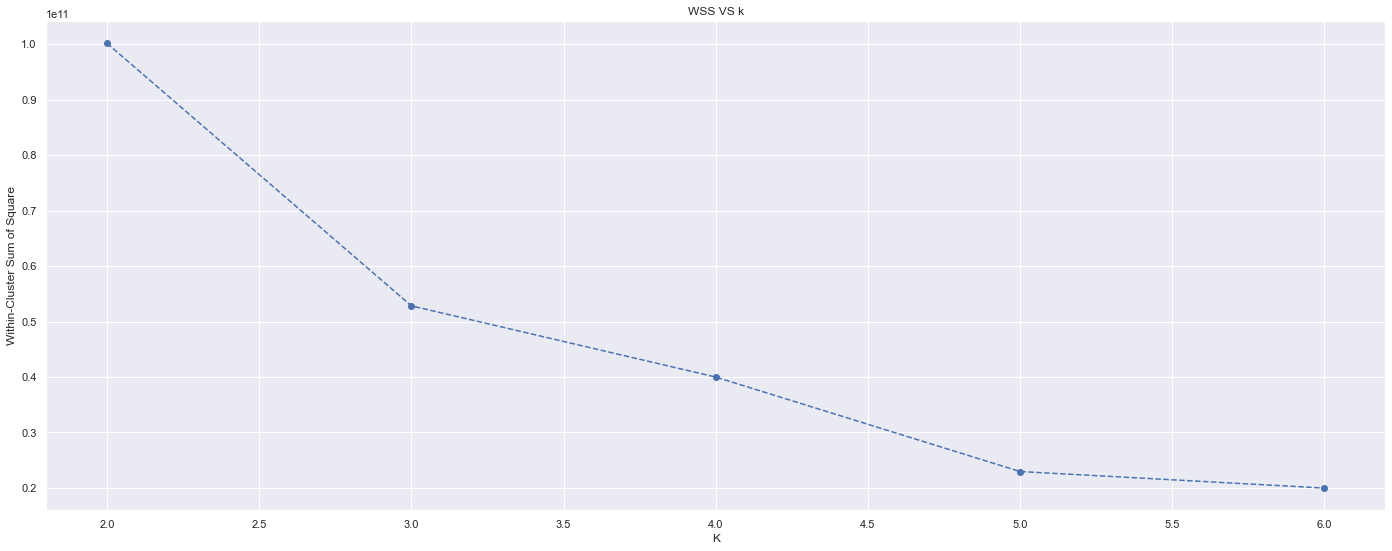

In [236]:
wss = []
for k in clusters:
    # model definition  
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )
    # model training 
    kmeans.fit( X )
    # validation 
    wss.append(kmeans.inertia_)
    
# plot wss
plt.plot (clusters, wss,linestyle='--', marker='o', color='b')
plt.xlabel ( 'K');
plt.ylabel ( 'Within-Cluster Sum of Square')
plt.title( 'WSS VS k');

In [234]:
wss

[100161464120.90097,
 52830442008.006935,
 39986557693.708206,
 22956286930.93175,
 19974463394.768734]

## 7.2. Silhouette Score

# <font color='red'> 8.0. Model Training </font>

# <font color='red'> 9.0. Cluster Analysis </font>

# <font color='red'> 10.0. Descrição dos dados </font>